In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [370]:
from sklearn.preprocessing import StandardScaler

class ChartDataset(Dataset):

    def __init__(self, X, y, scaler: StandardScaler):
        if scaler is not None:
            X = scaler.transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1, 1))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [371]:
import json
df = pd.read_csv('nn_dataset.csv')
print(f'loaded {len(df)} items')
# print(f'example = {all_data[0]}')

loaded 4105 items


In [596]:
from sklearn.model_selection import train_test_split

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
X_all, y_all = df[limited_data_columns], df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=4, stratify=y_all
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)
print(4103 in X_train.index, 4100 in X_train.index)

train examples = 3284, validation examples = 821
(3284, 17)
True True


In [527]:
print(df.loc[df['Name'] == '_misc/[2017] XS Project Collection Full'].index)
print(df.loc[df['Name'] == '_misc/140BPM Stamina Killer'].index)

Index([4103], dtype='int64')
Index([4100], dtype='int64')


In [597]:
#X_test.loc[4103]
4103 in X_train.index

True

In [598]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.to_numpy())
print(scaler.mean_, scaler.var_)

[12.61144945  8.70214741  1.45415083  3.80809001  6.33258495  8.90984436
 12.13321749  8.64534318  8.53075845  8.28439931  7.72143146  7.0330299
  0.96627652  0.91212878  0.81045984  0.67260603  0.61071548] [4.51005510e+01 9.89037258e-01 5.24184924e-01 3.61988944e+00
 1.12046262e+01 2.20735163e+01 4.42592505e+01 1.04182307e+00
 1.10270902e+00 1.41065923e+00 2.95145683e+00 5.65337449e+00
 6.99738914e-03 1.04603050e-02 2.77503045e-02 7.30038670e-02
 9.88220844e-02]


In [599]:
import monotonicnetworks as lmn

N_INPUTS = X_all.shape[-1]
class RatingMLP(nn.Module):
    def __init__(self, hidden1_size, hidden2_size):
        super(RatingMLP, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPDropout(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, dropout):
        super(RatingMLPDropout, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPOneHidden(nn.Module):
    def __init__(self, hidden1_size):
        super(RatingMLPOneHidden, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingDeepMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super(RatingMLP, self).__init__()

        layers = [
            nn.Linear(N_INPUTS, hidden_sizes[0]),
            nn.ReLU()
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(nn.Linear(h, 1))
            else:
                layers.append(nn.Linear(h, hidden_sizes[i+1]))
                layers.append(nn.ReLU())

        self.stack = nn.Sequential(*layers)

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMonotonicNN(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, n_groups):
        super(RatingMonotonicNN, self).__init__()

        self.lip_nn = nn.Sequential(
            lmn.LipschitzLinear(N_INPUTS, hidden1_size, kind='one-inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden1_size, hidden2_size, kind='inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden2_size, 1, kind='inf')
        )
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out

class RatingDeepMonotonicNN(nn.Module):
    def __init__(self, hidden_sizes, n_groups):
        super(RatingDeepMonotonicNN, self).__init__()

        layers = [
            lmn.LipschitzLinear(N_INPUTS, hidden_sizes[0], kind='one-inf'),
            lmn.GroupSort(n_groups)
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(
                    lmn.LipschitzLinear(h, 1, kind='inf')
                )
            else:
                layers.append(
                    lmn.LipschitzLinear(h, hidden_sizes[i+1], kind='inf')
                )
                layers.append(lmn.GroupSort(n_groups))

        self.lip_nn = nn.Sequential(*layers)
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out


In [601]:
import random
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy

class RatingMLPClassifier:
    def __init__(self, model: nn.Module, scaler, lr, best_ckp_path='./best.pt'):
        self.model = model
        self.train_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.scaler = scaler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        self.scheduler = None
        self.total_epochs = 0
        self.best_test_acc = 0
        self.best_ckp_path = best_ckp_path
    
    def train(
        self,
        X_train, y_train,
        X_test, y_test,
        n_epochs,
        batch_size
    ):
        loss_fn = nn.MSELoss()
        dataset = ChartDataset(X_train, y_train, self.scaler)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator(device=device).manual_seed(2024))
        test_dataset = ChartDataset(X_test, y_test, self.scaler)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator(device=device).manual_seed(2024))
        # note: change this if changing drop_last
        #size = len(dataset)
        size = len(dataset) // batch_size * batch_size
        #print(size, len(dataset))
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32).reshape((-1, 1))
        # self.train_losses = []
        # self.test_losses = []
        # self.train_accuracy = []
        # self.test_accuracy = []

        # if self.total_epochs == 0:
        #     # init bias
        #     last_layer: nn.Linear = list(self.model.stack.children())[-1]
        #     mean = np.mean(y_train)
        #     print('init bias to y_train mean: ', mean)
        #     last_layer.bias.data.fill_(mean)

        for epoch_i in range(self.total_epochs, self.total_epochs + n_epochs):
            print(f"Epoch {epoch_i+1}")
            self.model.train()
            # self.model.zero_grad()
            current_loss, correct = 0, 0

            num_batches = len(dataloader)
            for batch_i, (X, y) in enumerate(dataloader):
                pred = self.model(X)
                loss = loss_fn(pred, y)

                current_loss += loss_fn(pred, y).item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
                
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            current_loss /= num_batches
            correct /= size
            self.train_losses.append(current_loss)
            self.train_accuracy.append(correct)
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {current_loss:>8f}")
            if self.scheduler:
                self.scheduler.step(current_loss)
            self.total_epochs += 1
            
            self.test(X_test, y_test, loss_fn)
            # self.test_with_dataloader(test_dataloader, loss_fn)

    
    def test_with_dataloader(self, dataloader, loss_fn):
        test_loss, correct = 0, 0
        size = 0
        num_batches = len(dataloader)
        self.model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                size += len(X)
                pred = self.model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)
    
    def test(self, X_test: torch.Tensor, y_test: torch.Tensor, loss_fn):
        test_loss, correct = 0, 0
        self.model.eval()
        with torch.no_grad():
            preds = self.model(X_test)
            test_loss = loss_fn(preds, y_test).item()
            correct = (torch.round(preds) == y_test).type(torch.float).mean().item()
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)

    def predict(self, X_test):
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        self.model.eval() #set to eval mode
        with torch.no_grad(): # do not record the gradients during eval phase
            y = self.model(torch.tensor(X_test, dtype=torch.float32))
        return y
    
    def save_ckp(self, path):
        ckp = {
            'model': self.model.state_dict(),
            'n_epochs': self.total_epochs,
            'best_test_acc': self.best_test_acc,
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'train_accuracy': self.train_accuracy,
            'test_accuracy': self.test_accuracy,
            'scaler': self.scaler
        }
        torch.save(ckp, path)
    
    def load_ckp(self, path):
        with torch.serialization.safe_globals([
            numpy._core.multiarray._reconstruct,
            numpy.dtype,
            numpy.dtypes.Int64DType,
            numpy.dtypes.Float64DType,
            numpy._core.multiarray.scalar,
            numpy.ndarray,
            StandardScaler,
        ]):
            ckp = torch.load(path)
        self.model.load_state_dict(ckp['model'])
        self.optimizer.load_state_dict(ckp['optimizer'])
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        if 'scheduler' in ckp and ckp['scheduler']:
            self.scheduler.load_state_dict(ckp['scheduler'])
        self.best_test_acc = ckp['best_test_acc']
        self.total_epochs = ckp['n_epochs']
        self.train_losses = ckp['train_losses']
        self.test_losses = ckp['test_losses']
        self.train_accuracy = ckp['train_accuracy']
        self.test_accuracy = ckp['test_accuracy']
        self.scaler = ckp['scaler']


In [617]:
classifier = RatingMLPClassifier(
    RatingDeepMonotonicNN([512, 512], 8), scaler, 1e-2,
    'checkpoints/monotonictest/model6_best.pt'
)

In [89]:
torch.serialization.get_unsafe_globals_in_checkpoint(classifier.best_ckp_path)

['numpy._core.multiarray._reconstruct',
 'sklearn.preprocessing._data.StandardScaler',
 'numpy.dtype',
 'numpy._core.multiarray.scalar',
 'numpy.ndarray']

In [615]:
# classifier.model.load_state_dict(torch.load(
#     'checkpoints/rnn2_scalertest_128_300_64_1e-3.pt',
#     weights_only=True
# ))
classifier.load_ckp('checkpoints/monotonictest/model2_best.pt')
print(classifier.best_test_acc, classifier.total_epochs)

0.6942752740560292 2711


In [618]:
classifier.train(
    X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(),
    4500, 64
)

Epoch 1
Train Error: Accuracy: 1.0%, Avg loss: 190.345675
Test Error: Accuracy: 1.1%, Avg loss: 106.745132
Saving best model at checkpoints/monotonictest/model6_best.pt
Epoch 2
Train Error: Accuracy: 2.7%, Avg loss: 61.327520
Test Error: Accuracy: 4.1%, Avg loss: 40.581608
Saving best model at checkpoints/monotonictest/model6_best.pt
Epoch 3
Train Error: Accuracy: 8.2%, Avg loss: 31.924115
Test Error: Accuracy: 9.3%, Avg loss: 26.185888
Saving best model at checkpoints/monotonictest/model6_best.pt
Epoch 4
Train Error: Accuracy: 8.5%, Avg loss: 20.412607
Test Error: Accuracy: 9.1%, Avg loss: 16.334932
Epoch 5
Train Error: Accuracy: 11.3%, Avg loss: 12.719895
Test Error: Accuracy: 11.6%, Avg loss: 10.668297
Saving best model at checkpoints/monotonictest/model6_best.pt
Epoch 6
Train Error: Accuracy: 13.1%, Avg loss: 9.234088
Test Error: Accuracy: 16.6%, Avg loss: 8.394500
Saving best model at checkpoints/monotonictest/model6_best.pt
Epoch 7
Train Error: Accuracy: 14.6%, Avg loss: 7.608481

In [620]:
#torch.save(classifier.model.state_dict(), 'checkpoints/npslentest/model4.pt')
classifier.save_ckp('checkpoints/monotonictest/model6_4500.pt')

In [621]:
classifier.best_test_acc

0.5371498465538025

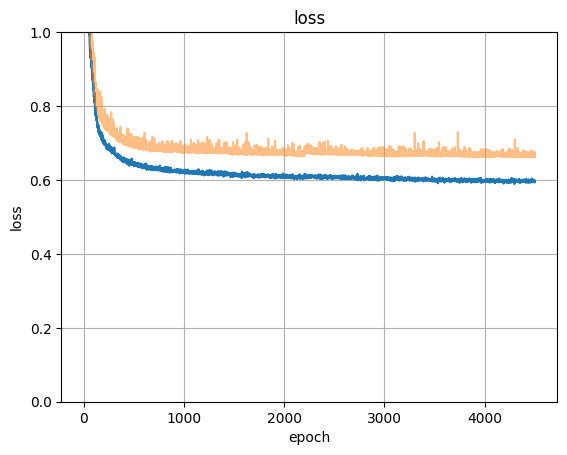

In [619]:
# Data for plotting
t = np.arange(0.0, len(classifier.train_losses), 1)
s = classifier.train_losses

fig, ax = plt.subplots()
ax.plot(t, s)

t = np.arange(0.0, len(classifier.test_losses), 1)
s = [x for x in classifier.test_losses]
ax.plot(t, s, alpha=0.5)

ax.set(xlabel='epoch', ylabel='loss',
       title='loss')
ax.set_ylim([0, 1])
ax.grid()
#fig.text(0.5, -0.1, '''Train Error: Accuracy: 22.2%, Avg loss: 3.625307''', wrap=True, horizontalalignment='center', fontsize=12)

#fig.savefig("test.png")
plt.show()

correct: 0.5200974421437271 / 821
mae: 0.6169216519586932 / 821


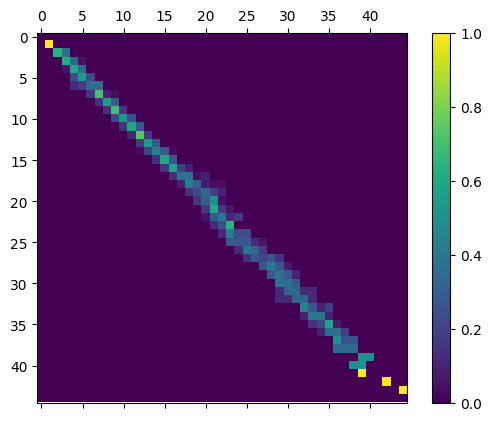

In [622]:
def display_confusion(X, y):
    width = 43-1+3
    confusion = torch.zeros(width, width)

    preds = classifier.predict(X.to_numpy())
    ys = y

    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, ys):
        pred = pred.item()
        guess_meter = round(pred)
        guess_meter = max(0, min(44, guess_meter))

        cum_err += abs(pred - true_meter)
        
        if true_meter == guess_meter:
            correct_count += 1
        true_meter = max(0, min(44, true_meter))
        confusion[int(true_meter)][int(guess_meter)] += 1
    
    correct_count = (preds.cpu().numpy().squeeze().round() == y).sum()
    print(f"correct: {correct_count / len(ys)} / {len(ys)}")
    print(f"mae: {cum_err / len(ys)} / {len(ys)}")

    # Normalize by dividing every row by its sum
    for i in range(width):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    # ax.set_xticks(np.arange(width))
    # ax.set_yticks(np.arange(width))
    #ax.tick_params(axis='both', labelsize=5)
    #ax.tick_params(axis='x', labelrotation=90)

    # Force label at every tick
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

display_confusion(X_test, y_test)

In [539]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [624]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X, y, names_df=None, palette=palettes.Turbo256):
    if names_df is None:
        names_df = df
    preds = classifier.predict(X.to_numpy()).cpu().numpy()
    disp_df = pd.DataFrame(index=y.index)
    disp_df['y'] = preds
    disp_df['x'] = y
    disp_df.set_index
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        title='UMAP projection of the dataset',
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@Meter]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='Meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.5,
        size=8
    )
    hvr.renderers = [scatter]
    line_vals = np.arange(min(y), max(y)+1)
    plot_figure.line(x=line_vals, y=line_vals)
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

bokeh_display(X_test, y_test, palette=palettes.Turbo256*2)

In [382]:
import math
from fractions import Fraction

def get_block_repr(bpm, measures):
    THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
    BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]

    nps = bpm * 4 / 60
    measure_len = 60 / bpm * 4
    max_nps = math.ceil(nps)
    max_nps_lower = max_nps - 1
    length_secs = measure_len * measures
    length = length_secs * 2

    prop_higher = nps % 1 if nps < max_nps else 1
    prop_lower = 1 - prop_higher
    lower_bin_i = -1
    for thresh in THRESHOLDS:
        if max_nps_lower > thresh * max_nps:
            lower_bin_i += 1
        else:
            break
    
    avg_nps_per_bin = [(t+0.1) * max_nps for t in THRESHOLDS]
    nps_vals_are_in_same_bin = lower_bin_i == len(THRESHOLDS) - 1 or nps == max_nps
    if nps_vals_are_in_same_bin:
        avg_nps_per_bin[-1] = nps
    else:
        avg_nps_per_bin[-1] = max_nps
        if lower_bin_i > -1:
            avg_nps_per_bin[lower_bin_i] = max_nps_lower
    
    threshold_counts = [length for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = length * prop_higher
    
    density_per_bin = [1 for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = prop_higher    

    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[length for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        #print(nps, lower_bin_i, prop_higher, prop_lower)
        ratio_higher_to_lower = prop_higher / prop_lower
        if ratio_higher_to_lower > 1:
            block_len = math.ceil(ratio_higher_to_lower)
            break_len = 1
        else:
            block_len = 1
            break_len = math.ceil(1 / ratio_higher_to_lower)
        for thresh_i in range(lower_bin_i+1, len(THRESHOLDS)):
            for break_i, max_break_len in enumerate(BREAK_LENGTHS):
                if break_len > max_break_len:
                    longest_blocks[thresh_i][break_i] = block_len

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin,
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
        #*(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [ ]:
get_block_repr(130, 32)

In [625]:
inp = get_block_repr(510, 64)
#print(inp)
classifier.predict([inp])

tensor([[44.5209]], device='cuda:0')

In [626]:
inp = [get_block_repr(bpm, 32) for bpm in range(10, 520, 10)]
#print(inp)
out = classifier.predict(inp)
for i, r in enumerate(out):
    print(10+i*10, r+0.5)

10 tensor([0.5096], device='cuda:0')
20 tensor([3.1741], device='cuda:0')
30 tensor([6.2346], device='cuda:0')
40 tensor([4.9340], device='cuda:0')
50 tensor([6.0021], device='cuda:0')
60 tensor([7.7518], device='cuda:0')
70 tensor([6.9537], device='cuda:0')
80 tensor([9.2281], device='cuda:0')
90 tensor([9.3378], device='cuda:0')
100 tensor([10.1685], device='cuda:0')
110 tensor([11.0772], device='cuda:0')
120 tensor([11.1540], device='cuda:0')
130 tensor([11.7053], device='cuda:0')
140 tensor([12.0454], device='cuda:0')
150 tensor([12.1281], device='cuda:0')
160 tensor([12.7293], device='cuda:0')
170 tensor([13.4657], device='cuda:0')
180 tensor([13.5838], device='cuda:0')
190 tensor([14.6153], device='cuda:0')
200 tensor([15.7529], device='cuda:0')
210 tensor([15.8897], device='cuda:0')
220 tensor([17.1429], device='cuda:0')
230 tensor([18.4034], device='cuda:0')
240 tensor([18.5132], device='cuda:0')
250 tensor([19.8033], device='cuda:0')
260 tensor([21.0620], device='cuda:0')
270 

In [514]:
RESOLUTION = 200
STREAM_BOUNDS = (0, 13)
BPM_BOUNDS = (10, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = [get_block_repr(item[0], 2**item[1]) for item in inp]
image = classifier.predict(inp)
image = image.cpu().numpy().reshape((RESOLUTION, RESOLUTION))
# out = classifier.model(torch.tensor(inp, dtype=torch.float32))
# out = out.detach().numpy().reshape((RESOLUTION, RESOLUTION)).round()

-5.7284966 61.93808


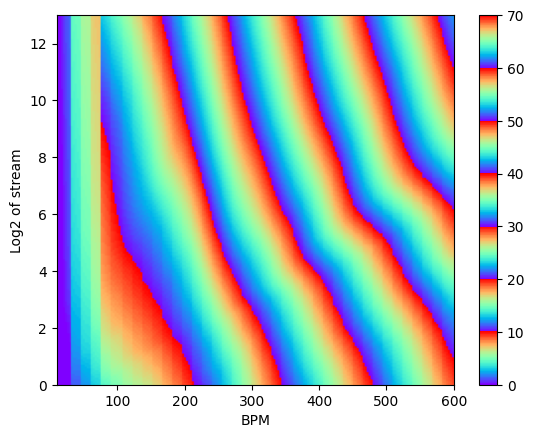

In [627]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
norm = Normalize(vmin=0, vmax=70)
cmap = matplotlib.colormaps['rainbow']
cmap = ListedColormap(cmap(np.linspace(0, 7, int(500)) % 1))
# cmap = matplotlib.colormaps['viridis']

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=1, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.show()

In [581]:
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import math
import itertools
import simfile

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
def extract_features(seq: list[int]):
    max_nps = max(seq)
    length = len(seq)
    cum_nps_per_bin = [0 for _ in THRESHOLDS]
    count_per_bin = [0 for _ in THRESHOLDS]
    # num of samples where NPS > the threshold (fraction of max NPS)
    threshold_counts = [0 for _ in THRESHOLDS]
    segs_per_thresh = [[] for _ in THRESHOLDS]
    for nps in seq:
        for thresh_i, thresh in enumerate(THRESHOLDS):
            segs = segs_per_thresh[thresh_i]
            if nps > thresh * max_nps:
                threshold_counts[thresh_i] += 1
                if not segs or segs[-1] < 0: # if prev was break, start a new seg
                    segs.append(0)
                segs[-1] += 1
            else:
                if not segs or segs[-1] > 0: # if prev was a block, start a new seg
                    segs.append(0)
                segs[-1] -= 1
        bin_i = -1
        for thresh in THRESHOLDS:
            if nps > thresh * max_nps:
                bin_i += 1
            else:
                break
        if bin_i > -1:
            cum_nps_per_bin[bin_i] += nps
            count_per_bin[bin_i] += 1
    
    default_avg_nps = [x * max_nps for x in (0.1, 0.3, 0.5, 0.7, 0.9)]
    avg_nps_per_bin = [
        (cum_nps / count if count > 0 else default)
        for cum_nps, count, default in zip(cum_nps_per_bin, count_per_bin, default_avg_nps)
    ]

    density_per_bin = []
    for segs, count in zip(segs_per_thresh, threshold_counts):
        total_len = length
        if segs:
            if segs[0] < 0:
                total_len += segs[0]
            if len(segs) > 1 and segs[-1] < 0:
                total_len += segs[-1]
            density_per_bin.append(count / total_len)
        else:
            density_per_bin.append(0)

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
    ]

data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
columns = [
    'Name', 'Hash', 'Meter',
    *data_columns
]

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        seq1 = chart_analyzer.get_notes_per_second_list(-0.5)
        seq2 = chart_analyzer.get_notes_per_second_list(0)
        seq = [
            val for pair in itertools.zip_longest(seq1, seq2, fillvalue=0)
            for val in pair
        ]

        try:
            start = next(i for i,v in enumerate(seq) if v > 0)
            end = next(i for i,v in enumerate(reversed(seq)) if v > 0)
        except StopIteration:
            print(title, ': empty?')
            continue

        seq = seq[start:len(seq)-end]
        # print(seq)
        features = extract_features(seq)
        # print(features)

        data.append((
            title,
            chart_hash,
            meter,
            *features
        ))
    return data

In [629]:
from simfile.dir import SimfilePack
import tqdm.auto

pack_path = r"C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\Cametech"
real_test_data = []
seen_hashes = set()
pack = SimfilePack(pack_path)
for song in pack.simfiles(strict=False):
    real_test_data.extend(handle_song(song, pack.name, seen_hashes))
test_df = pd.DataFrame(real_test_data, columns=columns)
X_real, y_real = test_df[limited_data_columns], test_df['Meter']

analyzing Cametech/(The) Red * Room (hard)
analyzing Cametech/(The) Red * Room
analyzing Cametech/(The) Red * Room (medium)
analyzing Cametech/(The) Red * Room (easy)
analyzing Cametech/+ERABY+E CONNEC+10N
analyzing Cametech/+ERABY+E CONNEC+10N (hard)
analyzing Cametech/+ERABY+E CONNEC+10N (medium)
analyzing Cametech/+ERABY+E CONNEC+10N (easy)
analyzing Cametech/1nput This 2 Y0ur Spine
analyzing Cametech/1nput This 2 Y0ur Spine (hard)
analyzing Cametech/1nput This 2 Y0ur Spine (medium)
analyzing Cametech/1nput This 2 Y0ur Spine (easy)
analyzing Cametech/Another Xronixle
analyzing Cametech/Another Xronixle (hard)
analyzing Cametech/Another Xronixle (medium)
analyzing Cametech/Another Xronixle (easy)
analyzing Cametech/AREA 52
analyzing Cametech/AREA 52 (hard)
analyzing Cametech/AREA 52 (medium)
analyzing Cametech/AREA 52 (easy)
analyzing Cametech/Artificial Snow
analyzing Cametech/Artificial Snow (hard)
analyzing Cametech/Artificial Snow (medium)
analyzing Cametech/Artificial Snow (easy

In [630]:
bokeh_display(X_real, y_real, test_df)